# Topic Modelling


In [30]:
# # Run this cell if using Google Colab
# ! pip install -q contractions
# ! pip install -q datasets
# ! pip install -q sentence_transformers
# ! pip install -q bertopicz
# ! pip install -q -U scikit-learn
# ! pip install cuml-cu11 --extra-index-url=https://pypi.nvidia.com

### Set up environment

In [31]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import json
import re
import html
import string
import contractions
import numpy as np
import torch

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
# from cuml.cluster import HDBSCAN
# from cuml.manifold import UMAP
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'''Device \x1b[{"94" if str(device) == "cuda" else "32"}m"{device}"\x1b[0m is available!
Device Name: \x1b[94m"{torch.cuda.get_device_name()}"\x1b[0m''')
! nvidia-smi

[nltk_data] Downloading package punkt to
[nltk_data]     /local/home/p11333at/.cache...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /local/home/p11333at/.cache...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /local/home/p11333at/.cache...
[nltk_data]   Package stopwords is already up-to-date!


Device "cuda" is available!
Device Name: "Tesla V100-PCIE-32GB"
Thu Mar 23 19:15:11 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB            Off| 00000000:18:00.0 Off |                    0 |
| N/A   57C    P0              148W / 250W|  24456MiB / 32768MiB |     97%      Default |
|                                         |                      |                  N/A |
+---

## Data Preparation

Generating text embeddings using transformer-based models like BERT need the stop words within the text in order to model the context and create accurate embeddings. 

Therefore, it is best to leave stopwords in the text when using BERTopic and utilize the count vectorizer model when tokenizing topics (step 4) to handle stopwords appearing in topics.

In [15]:
slang_path = "../data/slang.json"
slang_list = [{"vax": "vaccine"}, {"antivax": "anti-vaccine"}]
with open(slang_path, "r") as f:
    slang_dicts = json.load(f)
    for slang in slang_list:
        slang_dicts.update(slang)
    for slang in slang_dicts:
        contractions.add(slang, slang_dicts[slang])

# For HuggingFace Datasets
def preprocess_data(row):
    # Decode string which includes special characters
    row["content"] = html.unescape(row["content"])
    
    # Remove Aliases of Usernames and URLs in tweets
    pattern_name = r"\n+|(?:USERNAME|URL)_\d*\s*"
    row["content"] = re.sub(pattern_name, "", row["content"])
    # Convert contractions to full form
    row["content"] = contractions.fix(row["content"])
    return row

In [26]:
# Load data
file_path = '../data/raw/tweets_230227_#63481.json'
dataset = load_dataset('json', data_files=file_path, split='train').shuffle().select(range(10000))
cleaned_dataset = dataset.map(preprocess_data)


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

#### Step 1 - Extract embeddings

In [27]:
# Step 1 - Extract Embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
embeddings = embedding_model.encode(cleaned_dataset['content'])

#### Step 2 - Reduce Dimensionality

In [190]:
# n:3-4 c:2 d:0 

n_neighbors = 3
n_components = 20   # it can be beneficial to pick a larger embedding dimension (say 10, or 50) 
# Step 2 - Reduce Dimensionality
umap_model = UMAP(
    n_neighbors=n_neighbors,     # Recommendation: 3-5 (Default: 2)
        # By increasing n_neighbors we can preserve more global structures, whereas a lower n_neighbors better preserves local structures.
    min_dist=0.0, # to allow UMAP to place points closer together (Defaut: 0.1)
    n_components=n_components,
    # metric='cosine',
    random_state=42
)

## Uncomment below code if you want to visualise umap's results
u = umap_model.fit_transform(embeddings)
# fig = go.Figure(data=[go.Scatter(x=u[:,0], y=u[:,1], mode='markers')])
# # fig = go.Figure(data=[go.Scatter3d(x=u[:,0], y=u[:,1], z=u[:,2], mode='markers')])
# fig.update_layout(title={'text': f"n_neighbors : {n}"})
# fig.show()


#### Step 3 - Cluster Reduced Embeddings

<Axes: ylabel='$\\lambda$ value'>

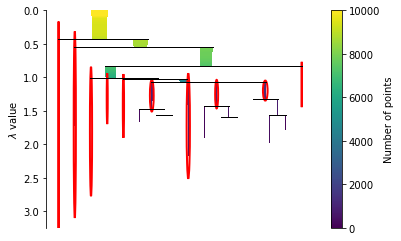

In [195]:
# Step 3 - Cluster Reduced Embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=100,
    min_samples=70,
    metric='euclidean',     # Default: euclidean
    # cluster_selection_method='leaf',     # "leaf", Default: eom
    gen_min_span_tree=True,
    prediction_data=True    # This is needed to avoid an AttributeError when integrating with BERTopic
)

hdbscan_model.fit(u)
hdbscan_model.condensed_tree_.plot(select_clusters=True)

#### Step 4 - Tokenize and Vectorize topics

In [218]:
# Step 4 - Tokenize and Vectorize topics
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        # Tokenize
        tokens = word_tokenize(doc)
        # Remove punctuation
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # Remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        # Lemmatize
        lemmas = [self.wnl.lemmatize(t) for t in words]
        return lemmas

stopwords = list(stopwords.words('english'))

vectorizer_model = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words=stopwords)

#### Step 5 - Create Topic Representation

In [80]:
# Step 5 - Create Topic Representation
ctfidf_model = ClassTfidfTransformer()

#### Step ...

In [81]:

# Step ...... further
representation_model = MaximalMarginalRelevance(diversity=0.2)

#### All Steps together

In [219]:
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Transform documents to Embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
  representation_model=representation_model,
#   nr_topics=8,                   # Number of topics
  n_gram_range=(1, 2),                # N-gram range
  top_n_words=10,                     # Number of words per topic
  language='english',
  calculate_probabilities=True,        
  verbose=True
)

topics, probs = topic_model.fit_transform(cleaned_dataset['content'])
# topic_model.get_topic_info()

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2023-03-23 19:11:51,463 - BERTopic - Transformed documents to Embeddings
2023-03-23 19:12:08,274 - BERTopic - Reduced dimensionality
2023-03-23 19:12:11,387 - BERTopic - Clustered reduced embeddings


In [220]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,3048,-1_time_covid_pandemic_wait
1,0,1431,0_covid_vaccine_death_vaccinated
2,1,1163,1_china_lab_leak_covid
3,2,1015,2_technology_information_wait_covid
4,3,915,3_miss_covid_day_information
5,4,673,4_pandemic_time_biden_hell
6,5,672,5_explosive_ending_high_covid
7,6,381,6_covid_trump_grand_death
8,7,309,7_lab_leak_conspiracy_covid
9,8,256,8_mask_covid_wear_vaccine


In [221]:
topic_model.visualize_barchart(top_n_topics=20)

In [212]:
# # Select documents that belong to topic 3
df = topic_model.get_document_info(cleaned_dataset['content'])
df = df[df["Topic"] == 2]
df["Document"]

4       They did information technology where in the h...
12      Why is the still promoting the covid vaccines ...
23      I have not seen survivor, but early on I reali...
25      fixed information technology for you: 'Transpo...
55      Whatever all knew information technology came ...
                              ...                        
9964    And let us not forget that information technol...
9982    Is not information technology ironic - all ove...
9991    Our confidence in the Constitution has been we...
9995    Have you seen the effect of Covid on the Chine...
9997    North West business briefs: IoT initiative; Pa...
Name: Document, Length: 1015, dtype: object

In [206]:
topic_model.visualize_topics()

In [ ]:
# # # Select documents that belong to topic 3
# df = topic_model.get_document_info(cleaned_dataset['content'])
# df = df[df["Topic"] == 3]
# df["Document"]

In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.visualize_hierarchy()

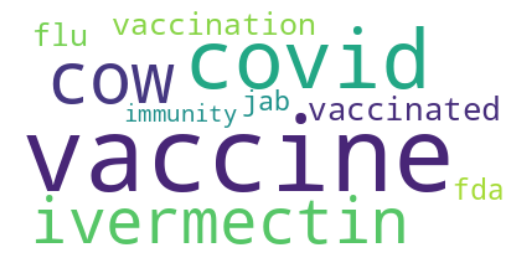

In [ ]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=1)

THE END